# Combined Fit
Combined (simultaneous) fit of two histogram with separate functions
and some common parameters

N.B. this macro must be compiled with ACliC

In [1]:
%%cpp -d
#include <Fit/Fitter.h>
#include <Fit/BinData.h>
#include <Fit/Chi2FCN.h>
#include <TH1.h>
#include <Math/WrappedMultiTF1.h>
#include <HFitInterface.h>
#include <TCanvas.h>
#include <TStyle.h>

Definition of shared parameter
 background function

In [2]:
int iparB[2] = {
   0, // exp amplitude in B histo
   2  // exp common parameter
};

Signal + background function

In [3]:
int iparSB[5] = {
   1, // exp amplitude in S+B histo
   2, // exp common parameter
   3, // Gaussian amplitude
   4, // Gaussian mean
   5  // Gaussian sigma
};

Create the globalchi2 structure

In [4]:
struct GlobalChi2 {
   GlobalChi2(ROOT::Math::IMultiGenFunction &f1, ROOT::Math::IMultiGenFunction &f2) : fChi2_1(&f1), fChi2_2(&f2) {}

   // parameter vector is first background (in common 1 and 2)
   // and then is signal (only in 2)
   double operator()(const double *par) const
   {
      double p1[2];
      for (int i = 0; i < 2; ++i)
         p1[i] = par[iparB[i]];

      double p2[5];
      for (int i = 0; i < 5; ++i)
         p2[i] = par[iparSB[i]];

      return (*fChi2_1)(p1) + (*fChi2_2)(p2);
   }

   const ROOT::Math::IMultiGenFunction *fChi2_1;
   const ROOT::Math::IMultiGenFunction *fChi2_2;
};

Load the file & define histograms

In [5]:
TFile *file = TFile::Open("../Inv_mass_gghasOneL_DNN_HL.root");
file->GetObject("Continuum_Bkg",Continuum_Bkg);
file->GetObject("GGHH",GGHH);
file->GetObject("GGH",GGH);
file->GetObject("VBFH",VBFH);
file->GetObject("VH",VH);
file->GetObject("ttH",ttH);
file->GetObject("tHq",tHq);

TH1D *hB = new TH1D("hB", "Cont. Bkg.", 80, 100, 180);
TH1D *hSH = new TH1D("hSH", "Single H", 80, 100, 180);
TH1D *hFB = new TH1D("hFB", "Full Bkg.", 80, 100, 180);
TH1D *hSB = new TH1D("hSB", "histo Signal + Full Bkg.", 80, 100, 180);
TH1D *hPD = new TH1D("hPD", "Pseudo-data", 80, 100, 180);


TF1 *fB = new TF1("fB", "expo", 100, 180);
fB->SetParameters(120, -0.03);

hB->Add(Continuum_Bkg);
hSH->Add(GGH);
hSH->Add(VBFH);
hSH->Add(VH);
hSH->Add(ttH);
hSH->Add(tHq);

TH1D *hAll = new TH1D("hAll", "histo for pseudo data", 80, 100, 180);
hAll->Add(hB);
hAll->Add(hSH);
hAll->Add(GGHH);

hSH->Scale(10);

hFB->Add(hB);
hFB->Add(hSH);

hSB->Add(hFB);
GGHH->Scale(1000);
hSB->Add(GGHH);

Perform now global fit

In [6]:
TF1 *fSB = new TF1("fSB", "expo + gaus(2)", 100, 180);
fSB->SetParNames("Expo Amplitude","Expo slope", "Gaus Amplitude", "Gaus Mean", "Gaus Sigma");

TF1 *fFB = new TF1("fFB", "expo + gaus(2)", 100, 180);
fFB->SetParNames("Expo Amplitude","Expo slope", "Gaus Amplitude", "Gaus Mean", "Gaus Sigma");

TF1 *fAll = new TF1("fAll", "expo + gaus(2)", 100, 180);

ROOT::Math::WrappedMultiTF1 wfB(*fB, 1);
ROOT::Math::WrappedMultiTF1 wfFB(*fFB, 1);
ROOT::Math::WrappedMultiTF1 wfSB(*fSB, 1);
ROOT::Math::WrappedMultiTF1 wfAll(*fAll, 1);

Set the data range

In [7]:
ROOT::Fit::DataOptions opt;
ROOT::Fit::DataRange rangeB;
rangeB.SetRange(100, 180);
ROOT::Fit::BinData dataB(opt, rangeB);
ROOT::Fit::FillData(dataB, hB);

ROOT::Fit::DataRange rangeFB;
rangeFB.SetRange(100, 180);
ROOT::Fit::BinData dataFB(opt, rangeFB);
ROOT::Fit::FillData(dataFB, hFB);

ROOT::Fit::DataRange rangeSB;
rangeSB.SetRange(100, 180);
ROOT::Fit::BinData dataSB(opt, rangeSB);
ROOT::Fit::FillData(dataSB, hSB);

ROOT::Fit::DataRange rangeAll;
rangeAll.SetRange(100, 180);
ROOT::Fit::BinData dataAll(opt, rangeAll);
ROOT::Fit::FillData(dataAll, hAll);

ROOT::Fit::Chi2Function chi2_B(dataB, wfB);
ROOT::Fit::Chi2Function chi2_FB(dataFB, wfFB);
ROOT::Fit::Chi2Function chi2_SB(dataSB, wfSB);
ROOT::Fit::Chi2Function chi2_All(dataAll, wfAll);

GlobalChi2 globalChi2(chi2_B, chi2_SB);
GlobalChi2 globalChi2FB(chi2_B, chi2_FB);
GlobalChi2 globalChi2All(chi2_B, chi2_All);

ROOT::Fit::Fitter fitterS;
ROOT::Fit::Fitter fitterFB;
ROOT::Fit::Fitter fitterAll;

const int Npar = 6;
double par0[Npar] = {5, 5, -0.1, 100, 125, 10};
double par1[Npar] = {5, 5, -0.1, 100, 125, 2};

Create before the parameter settings in order to fix or set range on them

In [8]:
fitterS.Config().SetParamsSettings(6, par0);
fitterFB.Config().SetParamsSettings(6, par1);
fitterAll.Config().SetParamsSettings(6, par1);

Fix 5-th parameter

In [9]:
fitterS.Config().ParSettings(4).Fix();
fitterFB.Config().ParSettings(4).Fix();
fitterAll.Config().ParSettings(4).Fix();

Set limits on the 3-rd and 4-th parameter

In [10]:
fitterS.Config().ParSettings(2).SetLimits(-100, -1.E-6);
fitterS.Config().ParSettings(3).SetLimits(0, 100000);
fitterS.Config().ParSettings(3).SetStepSize(5);

fitterS.Config().MinimizerOptions().SetPrintLevel(0);
fitterS.Config().SetMinimizer("Minuit2", "Migrad");

fitterFB.Config().ParSettings(2).SetLimits(-100, -1.E-6);
fitterFB.Config().ParSettings(3).SetLimits(0, 100000);
fitterFB.Config().ParSettings(3).SetStepSize(5);

fitterFB.Config().MinimizerOptions().SetPrintLevel(0);
fitterFB.Config().SetMinimizer("Minuit2", "Migrad");

fitterAll.Config().ParSettings(2).SetLimits(-100, -1.E-6);
fitterAll.Config().ParSettings(3).SetLimits(0, 100000);
fitterAll.Config().ParSettings(3).SetStepSize(5);

fitterAll.Config().MinimizerOptions().SetPrintLevel(0);
fitterAll.Config().SetMinimizer("Minuit2", "Migrad");

Fit fcn function directly
 (specify optionally data size and flag to indicate that is a chi2 fit)

In [11]:
fitterS.FitFCN(6, globalChi2, 0, dataB.Size() + dataSB.Size(), true);
ROOT::Fit::FitResult resultB = fitterS.Result();

fitterFB.FitFCN(6, globalChi2FB, 0, dataB.Size() + dataFB.Size(), true);
ROOT::Fit::FitResult resultFB = fitterFB.Result();

fitterAll.FitFCN(6, globalChi2All, 0, dataB.Size() + dataAll.Size(), true);
ROOT::Fit::FitResult resultAll = fitterAll.Result();

resultB.Print(std::cout);
resultFB.Print(std::cout);

TCanvas *c1 = new TCanvas("Simfit", "Simultaneous fit of two histograms", 800, 600);
gStyle->SetOptFit(1111);


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      235.481
NDf                       =          155
Edm                       =  5.34293e-08
NCalls                    =          679
Par_0                     =      12.0504   +/-   0.111808    
Par_1                     =      12.0533   +/-   0.113699    
Par_2                     =   -0.0321422   +/-   0.000841678  	 (limited)
Par_3                     =       2077.9   +/-   361.796      	 (limited)
Par_4                     =          125                      	 (fixed)
Par_5                     =      3.00499   +/-   0.64148     

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      234.971
NDf                       =          155
Edm                       =  1.43466e-08
NCalls                    =          701
Par_0                     =       12.051   +/-   0.111858    
Par_1                     =      12.0533   +/-   0.113774   

Prepare to draw & add pseudo-data

In [12]:
TH1D *h = new TH1D("h", "Signal+Bkg.", 80, 100, 180);

fB->SetFitResult(resultB, iparB);
fB->SetRange(rangeB().first, rangeB().second);
fB->SetLineColor(kBlue);
fB->SetLineStyle(kDashed);
h->GetListOfFunctions()->Add(fB);

fFB->SetFitResult(resultFB, iparSB);
fFB->SetRange(rangeFB().first, rangeFB().second);
fFB->SetLineColor(kGreen);
h->GetListOfFunctions()->Add(fFB);

fSB->SetFitResult(resultB, iparSB);
fSB->SetRange(rangeSB().first, rangeSB().second);
fSB->SetLineColor(kRed);
h->GetListOfFunctions()->Add(fSB);

h->FillRandom("fAll",fAll->Integral(100,180));

Draw

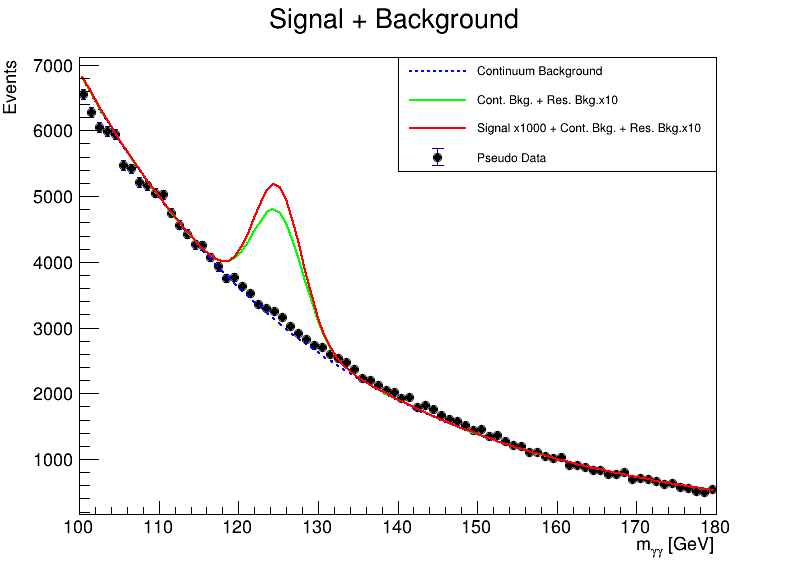

In [13]:
h->SetTitle("Signal + Background");
h->GetXaxis()->SetTitle("m_{#gamma#gamma} [GeV]");
h->GetYaxis()->SetTitle("Events");
h->SetMarkerStyle(20);
h->Draw("E1");
h->SetStats(0); //0 & 1 toggle statistics box

auto legend = new TLegend(0.5,0.7,0.9,0.9);
//legend->SetHeader("The Legend Title","C"); // option "C" allows to center the header
legend->AddEntry(fB,"Continuum Background","l");
legend->AddEntry(fFB,"Cont. Bkg. + Res. Bkg.x10","l");
legend->AddEntry(fSB,"Signal x1000 + Cont. Bkg. + Res. Bkg.x10","l");
legend->AddEntry(h,"Pseudo Data","ep");
legend->Draw();

c1->Draw();